# Import packages

In [2]:
from IPython.display import HTML

import numpy as np
import gym
import random

from time import clock
import matplotlib.pyplot as plt

%matplotlib inline

# Create environment

In [15]:
env = gym.make("FrozenLake8x8-v0")
RANDOM_STATE = 25

action_size = env.action_space.n
state_size = env.observation_space.n

64

# Value Iteration

In [74]:
def value_iteration(env, theta=0.0001, discount_factor=0.99, iterations=1000):
    # Look ahead one step at each possible action and next state (full backup)  
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    deltas = []
    times = []
    rewards = []
    steps = []
    V = np.zeros(env.nS)
        
    for i in range(iterations):
        # Stopping condition
        max_delta = 0
        delta_sum = 0
        start_time = clock()
        
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            max_delta = max(max_delta, np.abs(best_action_value - V[s]))
            delta_sum += np.abs(best_action_value - V[s])
            # Update the value function
            V[s] = best_action_value        

        times.append((clock() - start_time)*1000)
        rewards.append(V[0])
        deltas.append(delta_sum)
#         # Check if we can stop
#         deltas.append(delta)
#         if max_delta < theta:
#             break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return deltas, times, rewards, policy, V


vi_deltas, vi_times, vi_rewards, vi_policy, vi_V = value_iteration(env.env)

# Policy Iteration

In [75]:
def get_random_policy():
    policy = np.zeros((state_size, action_size))
    for i, rand_j in enumerate(np.random.choice(action_size, size=(state_size))):
        policy[i][rand_j] = 1

    return policy

def policy_eval(policy, env, discount_factor=0.99, theta=0.0001):
    # Initialize the value function
    V = np.zeros(env.nS)
    # While our value function is worse than the threshold theta
    while True:
        # Keep track of the update done in value function
        delta = 0
        # For each state, look ahead one step at each possible action and next state
        for s in range(env.nS):
            v = 0
            # The possible next actions, policy[s]:[a,action_prob]
            for a, action_prob in enumerate(policy[s]): 
                # For each action, look at the possible next states, 
                for prob, next_state, reward, done in env.P[s][a]: # state transition P[s][a] == [(prob, nextstate, reward, done), ...]
                    # Calculate the expected value function
                    v += action_prob * prob * (reward + discount_factor * V[next_state]) # P[s, a, s']*(R(s,a,s')+γV[s'])
                    # How much our value function changed across any states .  
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function update is below a threshold
        if delta < theta:
            break
    return np.array(V)

def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=0.99, iterations=1000):
    # Initiallize a policy arbitarily
    steps = []
    deltas = []
    rewards = []
    times = []
    policy = get_random_policy()
    V = policy_eval_fn(policy, env, discount_factor)
    
    for i in range(iterations):
        # Compute the Value Function for the current policy
        V_prev = np.array(V)
        start_time = clock()
        
        # Will be set to false if we update the policy
        policy_stable = True
        
        # Improve the policy at each state
        for s in range(env.nS):
            # The best action we would take under the currect policy
            chosen_a = np.argmax(policy[s])
            # Find the best action by one-step lookahead
            action_values = np.zeros(env.nA)
            for a in range(env.nA):
                for prob, next_state, reward, done in env.P[s][a]:
                    action_values[a] += prob * (reward + discount_factor * V[next_state])
            best_a = np.argmax(action_values)
            
            # Greedily (max in the above line) update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]

        V = policy_eval_fn(policy, env, discount_factor)
        times.append((clock() - start_time)*1000)

        rewards.append(V[0])
        deltas.append(np.fabs(V - V_prev).sum())
#         # Until we've found an optimal policy. Return it
#         if policy_stable:
#             return iterations, policy, V

    return deltas, times, rewards, policy, V

pi_deltas, pi_times, pi_rewards, pi_policy, pi_V = policy_improvement(env.env)

# Q-Learning Hyperparameters

In [128]:
learning_rate = 0.8           # Learning rate
max_steps = 1000                # Max steps per episode
gamma = 0.99                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.1            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

# Q-Learning Algorithm

In [187]:
# List of rewards
action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.ones((state_size, action_size))

def q_learning(episodes=1000, learning_rate=0.8, gamma=0.99, epsilon=1.0, min_epsilon=0.05, decay_rate=0.0005):
    max_epsilon = epsilon
    rewards = []
    q_rewards = []
    q_times = []
    q_deltas = []

    for episode in range(episodes):
        if episode % 500 == 0:
            print('Episode ' + str(episode))
        
        # Reset the environment
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        qtable_prev = np.array(qtable)
        start_time = clock()

        for step in range(max_steps):
            # 3. Choose an action a in the current world state (s)
            ## First we randomize a number
            exp_exp_tradeoff = random.uniform(0, 1)

            ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(qtable[state,:])

            # Else doing a random choice --> exploration
            else:
                action = env.action_space.sample()

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

            total_rewards += reward

            # Our new state is state
            state = new_state

            # If done (if we're dead) : finish episode
            if done == True:
                break

        q_times.append((clock() - start_time)*1000)

        # Create a deterministic policy using the optimal value function
        q_policy = np.zeros([state_size, action_size])
        for s in range(state_size):
            best_action = np.argmax(qtable[s])
            q_policy[s, best_action] = 1.0

        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        rewards.append(total_rewards)
        V = policy_eval(q_policy, env.env)
        q_rewards.append(V[0])
        q_deltas.append(np.fabs(qtable - qtable_prev).sum())
        
    return q_deltas, q_times, q_rewards, q_policy, V

q_deltas, q_times, q_rewards, q_policy, q_V = q_learning(episodes=1000)

Episode 0
Episode 500


# Visualize policy

In [188]:
actions = {
    0: '<',
    1: 'v',
    2: '>',
    3: '^'
}

def visualize_policy(policy, values):
    dim = int(state_size**0.5)
    lake = [['#' for i in range(dim)] for _ in range(dim)]
    for i in range(dim):
        for j in range(dim):
            state = i * dim + j
            p = env.env.P[state]
            max_i = np.argmax(policy[state])
            if values[state] != 0 and values[state] != 1:
                lake[i][j] = actions[max_i]
            elif not (p[0][0][3] and p[1][0][3] and p[2][0][3] and p[3][0][3]):
                lake[i][j] = 'U'

    lake[dim - 1][dim - 1] = 'G'
    return lake


In [189]:
visualize_policy(pi_policy, pi_V)

[['^', '>', '>', '>', '>', '>', '>', '>'],
 ['^', '^', '^', '^', '^', '>', '>', 'v'],
 ['^', '^', '<', '#', '>', '^', '>', 'v'],
 ['^', '^', '^', 'v', '<', '#', '>', '>'],
 ['<', '^', '<', '#', '>', 'v', '^', '>'],
 ['<', '#', '#', 'v', '^', '<', '#', '>'],
 ['<', '#', 'v', '<', '#', '<', '#', '>'],
 ['<', 'v', '<', '#', 'v', '>', 'v', 'G']]

In [138]:
visualize_policy(vi_policy, vi_V)

[['^', '>', '>', '>', '>', '>', '>', '>'],
 ['^', '^', '^', '^', '^', '>', '>', 'v'],
 ['^', '^', '<', '#', '>', '^', '>', 'v'],
 ['^', '^', '^', 'v', '<', '#', '>', '>'],
 ['<', '^', '<', '#', '>', 'v', '^', '>'],
 ['<', '#', '#', 'v', '^', '<', '#', '>'],
 ['<', '#', 'v', '<', '#', '<', '#', '>'],
 ['<', 'v', '<', '#', 'v', '>', 'v', 'G']]

In [139]:
visualize_policy(q_policy, q_V)

[['^', 'v', '^', '>', 'v', 'v', '^', 'v'],
 ['v', '^', '>', 'v', '>', 'v', 'v', '>'],
 ['v', '<', 'v', '#', '^', '<', '<', 'v'],
 ['v', '>', '<', 'U', 'U', '#', '<', 'v'],
 ['>', '>', 'v', '#', 'U', 'U', 'v', '<'],
 ['^', '#', '#', 'U', 'U', 'U', '#', 'v'],
 ['U', '#', 'U', 'U', '#', 'U', '#', '>'],
 ['U', 'U', 'U', '#', 'U', 'U', 'U', 'G']]

# Charts

In [190]:
environment_name = 'Frozen Lake 8x8'

def plot_curves(vi, pi, q, title, xlabel, ylabel, ylim=None):
    total_step = len(vi)
    step = np.array(list(range(total_step)))
    plt.plot(step, np.array(vi), label='Value Iteration')
    plt.plot(step, np.array(pi), label='Policy Iteration')
    plt.plot(step, np.array(q[:total_step]), label='Q-Learning')
    plt.legend()
    plt.title('Frozen Lake 8x8 - ' + title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if ylim is not None:
        plt.ylim(0, ylim)
    
    plt.figure(figsize=(12,12))    
    plt.show()

def plot_q_curve(q, title, xlabel, ylabel, ylim=None):
    step = np.array(list(range(len(q))))
    plt.plot(step, np.array(q))
    plt.title('Frozen Lake 8x8 - Q-Learning ' + title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if ylim is not None:
        plt.ylim(0, ylim)
    
    plt.figure(figsize=(12,12))    
    plt.show()

### Reward plot

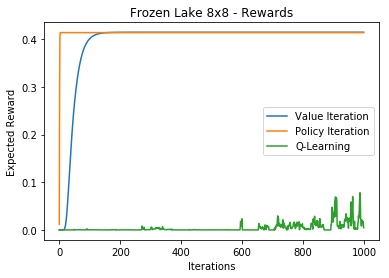

<Figure size 864x864 with 0 Axes>

In [191]:
plot_curves(vi_rewards, pi_rewards, q_rewards, 'Rewards', 'Iterations', 'Expected Reward')

### Convergence plot

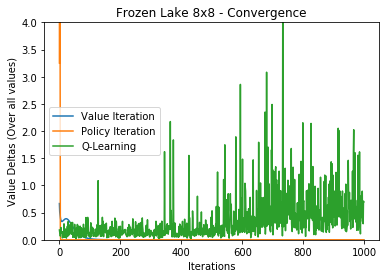

<Figure size 864x864 with 0 Axes>

In [192]:
plot_curves(vi_deltas, pi_deltas, q_deltas, 'Convergence', 'Iterations', 'Value Deltas (Over all values)', ylim=4)

### Computation time plot

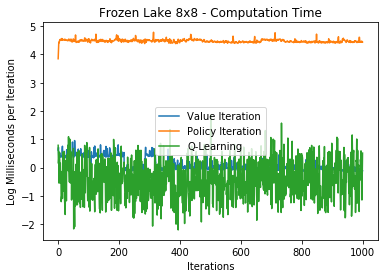

<Figure size 864x864 with 0 Axes>

In [193]:
plot_curves(np.log(vi_times), np.log(pi_times), np.log(q_times), 'Computation Time', 'Iterations', 'Log Milliseconds per Iteration')

# Q-Learning - More Iterations

In [195]:
q_deltas, q_times, q_rewards, q_policy, q_V = q_learning(episodes=5000, learning_rate=0.5, min_epsilon=0.2)

Episode 0
Episode 500
Episode 1000
Episode 1500
Episode 2000
Episode 2500
Episode 3000
Episode 3500
Episode 4000
Episode 4500


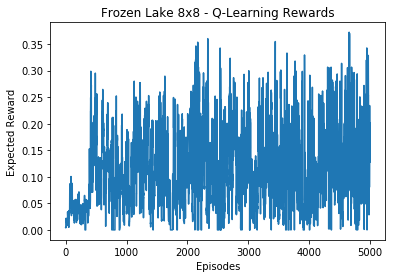

<Figure size 864x864 with 0 Axes>

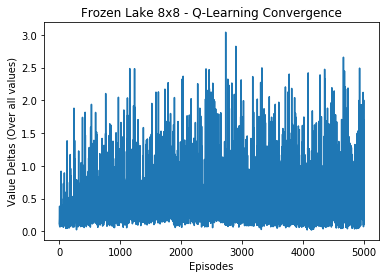

<Figure size 864x864 with 0 Axes>

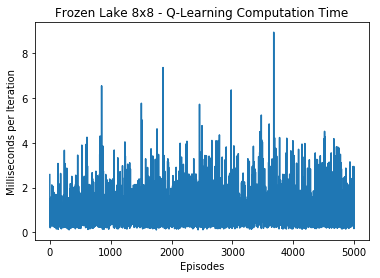

<Figure size 864x864 with 0 Axes>

[['v', 'v', '>', '>', '>', 'v', 'v', '>'],
 ['^', '^', '^', '^', '<', '>', '>', 'v'],
 ['^', '^', '<', '#', '^', '^', '>', '>'],
 ['>', '>', '<', '^', '^', '#', '^', '>'],
 ['>', '>', '>', '#', '^', '^', '^', '>'],
 ['v', '#', '#', '^', '>', '^', '#', '>'],
 ['v', '#', '^', '<', '#', '>', '#', '>'],
 ['^', '>', '^', '#', '^', '>', 'U', 'G']]

In [196]:
plot_q_curve(q_rewards, 'Rewards', 'Episodes', 'Expected Reward', ylim=None)
plot_q_curve(q_deltas, 'Convergence', 'Episodes', 'Value Deltas (Over all values)', ylim=None)
plot_q_curve(q_times, 'Computation Time', 'Episodes', 'Milliseconds per Iteration', ylim=None)
visualize_policy(q_policy, np.max(qtable, axis=-1))

# Q-Learning Hyperparameter Tuning

In [177]:
episodes = 5000

### Epsilon

In [198]:
q_deltas_e1, q_times, q_rewards, q_policy, q_V = q_learning(episodes=episodes, learning_rate=0.1, min_epsilon=0.05)
q_deltas_e5, q_times, q_rewards, q_policy, q_V = q_learning(episodes=episodes, learning_rate=0.1, min_epsilon=0.25)
q_deltas_e10, q_times, q_rewards, q_policy, q_V = q_learning(episodes=episodes, learning_rate=0.1, min_epsilon=0.5)

Episode 0
Episode 500
Episode 1000
Episode 1500
Episode 2000
Episode 2500
Episode 3000
Episode 3500
Episode 4000
Episode 4500
Episode 0
Episode 500
Episode 1000
Episode 1500
Episode 2000
Episode 2500
Episode 3000
Episode 3500
Episode 4000
Episode 4500
Episode 0
Episode 500
Episode 1000
Episode 1500
Episode 2000
Episode 2500
Episode 3000
Episode 3500
Episode 4000
Episode 4500


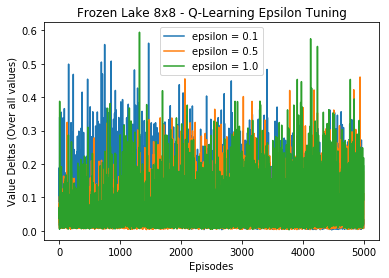

<Figure size 864x864 with 0 Axes>

In [200]:
step = np.array(list(range(len(q_deltas_e1))))
plt.plot(step, np.array(q_deltas_e1), label='epsilon = 0.1')
plt.plot(step, np.array(q_deltas_e5), label='epsilon = 0.5')
plt.plot(step, np.array(q_deltas_e10), label='epsilon = 1.0')
plt.legend()
plt.title('Frozen Lake 8x8 - Q-Learning Epsilon Tuning')
plt.xlabel('Episodes')
plt.ylabel('Value Deltas (Over all values)')

plt.figure(figsize=(12,12))    
plt.show()

### Learning Rate

In [147]:
q_deltas_lr1, _, _, q_policy_lr1, q_V_lr1 = q_learning(episodes=episodes, learning_rate=0.1)
q_deltas_lr4, _, _, q_policy_lr4, q_V_lr4 = q_learning(episodes=episodes, learning_rate=0.3)
q_deltas_lr8, _, _, q_policy_lr8, q_V_lr8 = q_learning(episodes=episodes, learning_rate=0.6)

Episode 0
Episode 500
Episode 1000
Episode 1500
Episode 2000
Episode 2500
Episode 3000
Episode 3500
Episode 4000
Episode 4500
Episode 0
Episode 500
Episode 1000
Episode 1500
Episode 2000
Episode 2500
Episode 3000
Episode 3500
Episode 4000
Episode 4500
Episode 0
Episode 500
Episode 1000
Episode 1500
Episode 2000
Episode 2500
Episode 3000
Episode 3500
Episode 4000
Episode 4500


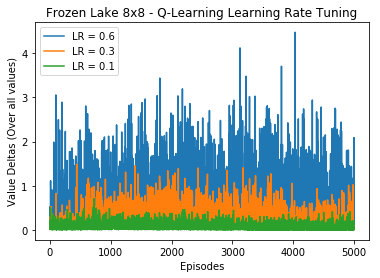

<Figure size 864x864 with 0 Axes>

In [180]:
step = np.array(list(range(len(q_deltas_lr1))))
plt.plot(step, np.array(q_deltas_lr8), label='LR = 0.6')
plt.plot(step, np.array(q_deltas_lr4), label='LR = 0.3')
plt.plot(step, np.array(q_deltas_lr1), label='LR = 0.1')
plt.legend()
plt.title('Frozen Lake 8x8 - Q-Learning Learning Rate Tuning')
plt.xlabel('Episodes')
plt.ylabel('Value Deltas (Over all values)')

plt.figure(figsize=(12,12))
plt.show()